# Image Captioning using Deep Learning: Assignment-3

*  In this assignment, we will use CNNs in [PyTorch](https://pytorch.org/docs/stable/index.html) for image classification.

* We have been using MNIST by flattening 28$\times$28 images to 784-sized vectors.

* This time, we will classify images from the CIFAR-10 dataset - dimension is 32$\times$32.

* Much of this notebook remains the same as for Assignment 2, just minor changes would be needed and this assignment won't take long.

**Feel free to redefine any pre-written cells below, just make sure to properly explain your work in Markdown and don't change the dataset**

## Import libraries here
PyTorch, NumPy, Matplotlib, ...
Even when equipped with PyTorch, NumPy and Matplotlib make your work easier for visualization etc.

Note the following method to **initialize the seed** for reproducibility of results, both for NumPy & PyTorch (CPU/CUDA).

In [720]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline
import os
import torch.optim as optim
import random
from sklearn.model_selection import StratifiedShuffleSplit
import torch
import torch.nn as nn
import torch.nn.functional as F

In [721]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(42)

## Load *Dataset*
**DON'T CHANGE THIS CODE**.

In [722]:
import torchvision
from torchvision import transforms, datasets

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

data_path = './'

train = datasets.CIFAR10(data_path, train=True, download=True, transform=transform)

test = datasets.CIFAR10(data_path, train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


# Your Code from here...

In [723]:
from torch.utils.data import random_split
train_ds, val_ds = random_split(train, [45000,5000])

from torch.utils.data import DataLoader
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)

In [724]:
# load the data set

# X = pass
# y = pass
# load the data set

X_test = val_ds.dataset.data
y_test = val_ds.dataset.targets





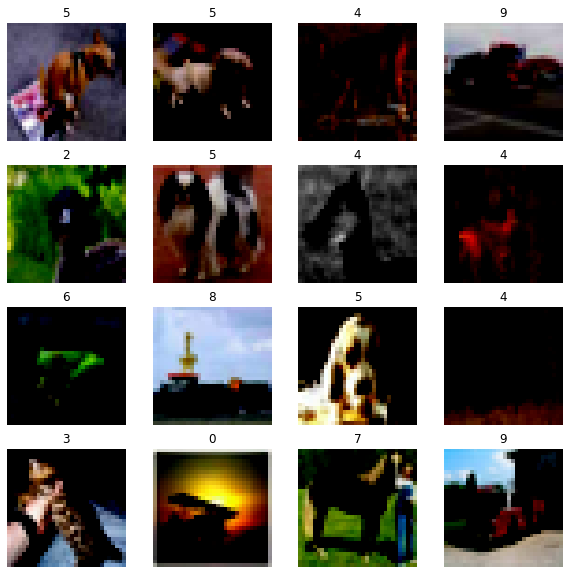

In [725]:
# display a 4x4 grid, 
# choose 16 images randomly, display the images as well as corresponding labels

# Select 16 random images from the train dataset
indices = random.sample(range(len(train_ds)), 16)
images = [np.transpose(train_ds[i][0].numpy(), (1, 2, 0)) for i in indices]
labels = [train_ds[i][1] for i in indices]

# Create a 4x4 grid of subplots
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

# Display the images and labels in the subplots
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.set_title(labels[i])
    ax.axis('off')

# Show the plot
plt.show()


## Creating a Dataset Class


In [726]:
# define your dataset class






## ```nn.Module``` for your model
In this segment, define a class for your model, it has to inherit from the ```nn.Module``` class. You must define two functions here - ```__init__``` and ```forward```, again pretty self-explanatory. Helper functions can also be implemented, your choice!

Look into the following ```torch``` layers beyond those you used in the second assignment and combine them to form your network, you can find more [here](https://pytorch.org/docs/stable/nn.html) -
- [```nn.Conv2d```](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
- [```nn.BatchNorm2d```](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)


In [727]:
# define a child class of nn.Module for your model
# specify the architecture here itself

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.bn1 = nn.BatchNorm2d(6)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.bn2 = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # add dropout to the first convolutional layer
        x = F.dropout2d(self.pool(nn.functional.relu(self.bn1(self.conv1(x)))), p=0.25)
        x = self.pool(nn.functional.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 16 * 5 * 5)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x







## Training loop
You can write a training loop but usually writing it within a function helps so that you can train in multiple passes with just one function call if you still don't see convergence of the loss. ```display_step``` is for you to display results on the validation set (which you must not have trained upon).

You will need to use ```zero_grad()```, ```backward()``` and multiple such functions here. Look for them in the tutorials given.

In [728]:
def train(model, optimizer, criterion, train_loader, display_step=None):
    for epoch in range(25):  # loop over the dataset multiple times
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

## Prediction & Accuracy
Prediction function should predict outputs using your trained model for a given **NumPy array** ```X_test``` and the output should be another **NumPy array**.

The accuracy function would be the same as before.

In [729]:
def predict(model, X_test):
    # Convert the input data to a PyTorch tensor
    X_test = torch.from_numpy(X_test)
    X_test = X_test.float()
    
    # Use the model's eval method to turn off dropout and other training-specific features
    model.eval()
    
    # Use the model's forward method to get the predictions for the input data
    with torch.no_grad():
        output = model(X_test)
    
    # Get the index of the maximum class probability for each sample
    _, predictions = torch.max(output, dim=1)
    
    # Convert the predictions to a NumPy array
    predictions = predictions.numpy()
    
    return predictions


In [730]:
def accuracy(pred, labels):
    labels = np.array(labels)

    correct_predictions = np.sum(pred == labels)

    acc = correct_predictions / len(pred)*100

    return acc

## Actually training your model
- Create a model, initialize it. Define optimizer for the model as well as loss criterion (you can actually set the seed here again, just in case you did some ```rand``` calls above for testing your functions).
- Define an instance of the dataset class, wrap it in a dataloader.
- Call the train function and train your model!


In [731]:
final_model = CNN()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(final_model.parameters(), lr=0.01, momentum=0.9)

train(final_model, optimizer, criterion, train_loader, display_step=None)




## Run your model for the validation dataset
Use your trained model to get predictions for the validation dataset you split earlier.

In [741]:
# X_test_np = X_test.numpy()
a=predict(final_model,X_test.transpose(0, 3, 1, 2))
c=accuracy(a,y_test)
print("Final Prediction ",c)

Final Prediction  41.199999999999996


In [733]:
a

array([1, 9, 9, ..., 9, 1, 1])

In [734]:
w=np.array(y_test)
w

array([6, 9, 9, ..., 9, 1, 1])

## Submission
To submit your solution, you will need to make a file with name ```model.py``` containing imports necessary to write the model class and the model class itself. It shouldn't do anything else when run. Other than this, save the trained model in a file named ```ass_3.pt```. When you are done with the assignment, commit the updated notebook, the ```model.py``` class file and the ```ass_3.pt``` model-weights file to the repository.

In [735]:
from google.colab import files
torch.save(final_model, 'ass_3.pt')
files.download('ass_3.pt') # download the file from the Colab session for submission

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Check if it got saved right!

In [742]:
# load the model, use predict function
model2 = torch.load('ass_3.pt')
# X_test_np2 = X_test.numpy()
predi=predict(model2,X_test.transpose(0, 3, 1, 2))
val=accuracy(predi,y_test)
print("Final Prediction after loading",val)


Final Prediction after loading 40.998000000000005
